In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train_cls = load_cls(path+"X_train_cls.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_cls.p")

In [5]:
print(len(X_train_cls))

75000


In [6]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [7]:
from sklearn import svm
from sklearn.preprocessing import MaxAbsScaler,StandardScaler

In [8]:
scaling = StandardScaler(with_mean=False).fit(X_train_cls)
X_train_z = scaling.transform(X_train_cls)
X_val_f = scaling.transform(X_val_cls)

In [38]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1,10],
     'gamma': [0.001, 0.01, 0.1, 1],
    'degree': [2,3,4,5]
 }

In [43]:
gs_clf = GridSearchCV(svm.SVC(verbose=True,probability=True,cache_size=7000,max_iter=n_iter,gamma='auto',kernel='poly'), 
                      parameters, cv=5, iid=True, n_jobs=4, verbose=4)

In [44]:
model = gs_clf.fit(X_train_z, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 88.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 403.4min
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed: 937.1min
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed: 1654.4min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 1718.3min finished


[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [45]:
model.best_score_

0.5639733333333333

In [46]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'C': 0.001, 'degree': 2, 'gamma': 0.001}
C: 0.001
degree: 2
gamma: 0.001


In [47]:
pickle.dump(model,open("SVM_CLS_Poly_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [48]:
X_test_cls = load_cls(path+"X_test_cls.p")
y_test = load_cls(path+"y_test.p")

In [49]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=model.best_params_['gamma'],
                        degree=model.best_params_['degree'],
                        kernel='poly',
                        C=model.best_params_['C'])

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    scaling2 = StandardScaler(with_mean=False).fit(X_train_cls[:eachTrain])
    X_train_f = scaling2.transform(X_train_cls[:eachTrain])
    #X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    #X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    #X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_cls)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_cls)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
[LibSVM]Train Time:0.06 sec
Validation Accuracy: 52.59%
Validation Time:1.52 sec
Test Accuracy: 51.14%
Test Time:1.52 sec
(0.33062592592592494, 0.09466666666666666, 0.3506666666666667)
MRR: 0.33062592592592494
MRR Time:2.05 sec
SampleSize: 500
[LibSVM]Train Time:1.29 sec
Validation Accuracy: 52.62%
Validation Time:7.65 sec
Test Accuracy: 50.00%
Test Time:7.91 sec
(0.2856666666666618, 0.0, 0.0)
MRR: 0.2856666666666618
MRR Time:8.56 sec
SampleSize: 1000
[LibSVM]Train Time:5.17 sec
Validation Accuracy: 54.15%
Validation Time:15.37 sec
Test Accuracy: 49.99%
Test Time:15.17 sec
(0.3212481481481474, 0.084, 0.344)
MRR: 0.3212481481481474
MRR Time:15.71 sec
SampleSize: 10000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:140.65 sec
Validation Accuracy: 53.53%
Validation Time:31.04 sec
Test Accuracy: 55.89%
Test Time:30.45 sec
(0.5403037037037053, 0.308, 0.6973333333333334)
MRR: 0.5403037037037053
MRR Time:31.08 sec
SampleSize: 20000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:283.68 sec
Validation Accuracy: 53.76%
Validation Time:30.46 sec
Test Accuracy: 53.99%
Test Time:30.42 sec
(0.5057349206349223, 0.276, 0.6466666666666666)
MRR: 0.5057349206349223
MRR Time:30.89 sec
SampleSize: 50000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:699.66 sec
Validation Accuracy: 54.03%
Validation Time:30.45 sec
Test Accuracy: 50.00%
Test Time:30.42 sec
(0.5098666666666686, 0.2786666666666667, 0.644)
MRR: 0.5098666666666686
MRR Time:31.10 sec
SampleSize: 75000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:1051.82 sec
Validation Accuracy: 53.94%
Validation Time:30.44 sec
Test Accuracy: 50.00%
Test Time:30.43 sec
(0.5091777777777798, 0.2813333333333333, 0.6473333333333333)
MRR: 0.5091777777777798
MRR Time:30.85 sec
[0.5259, 0.5262, 0.5415, 0.5353, 0.5376, 0.5403, 0.5394]
[0.5114, 0.5, 0.4999, 0.5589, 0.5399, 0.5, 0.5]
[0.33062592592592494, 0.2856666666666618, 0.3212481481481474, 0.5403037037037053, 0.5057349206349223, 0.5098666666666686, 0.5091777777777798]
[0.09466666666666666, 0.0, 0.084, 0.308, 0.276, 0.2786666666666667, 0.2813333333333333]
[0.3506666666666667, 0.0, 0.344, 0.6973333333333334, 0.6466666666666666, 0.644, 0.6473333333333333]


In [52]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Cls_Poly_Accuracy.png")
    #plt.show()

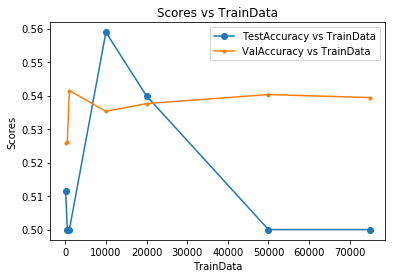

In [53]:
accuracyVisualization()

In [54]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='o')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Cls_Poly_Mrr.png")
    plt.show()

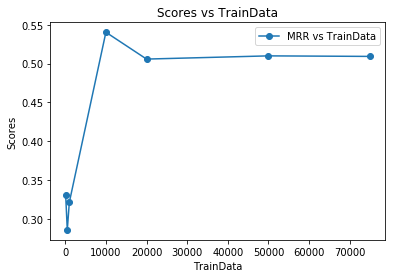

In [55]:
mrrVisualization()

In [56]:
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("SVM_Cls_Poly_Precision.png")
    plt.show()

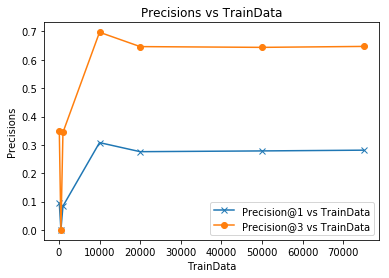

In [57]:
precisionVisualization()

In [10]:
bmodel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=0.001,
                        degree=2,
                        kernel='poly',
                        C=0.001)

stime=time.time()
#X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
bmodel.fit(X_train_z,y_train)   
print("Train Time:%.2f sec"%(time.time()-stime))

[LibSVM]Train Time:896.20 sec


/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [11]:
bmodel.coef_.argsort()[0][-10:][::-1]

AttributeError: coef_ is only available when using a linear kernel

In [12]:
bmodel.coef_.argsort()[0][-15:][::-1]

AttributeError: coef_ is only available when using a linear kernel

In [ ]:
pickle.dump(bmodel,open("SVM_Cls_Poly_Best.pkl",'wb'))